---
title: "ガウス過程と機械学習 3章 ガウス過程回帰のパラメータ推定"
date: 2024-08-16
categories: [ml]
---


[前回](./2024-08-14_gauss_sec3) からの続き

テキスト 3.5 のパラメータ推定をやってみる。

trainデータを使って対数尤度が最大になるような $\theta$ を探索する。  
対数尤度の式は (3.92) の $-\log |K_\theta| - y^T K^{-1}_\theta y$ 。

前回同様テストデータなどは以下の記事から借りている。

[『ガウス過程と機械学習』Pythonのnumpyだけで実装するガウス過程回帰 #機械学習プロフェッショナルシリーズ - Qiita](https://qiita.com/ogi-iii/items/cf16e13ec09340016121)


In [13]:
# テストデータ生成

import numpy as np
np.random.seed(seed=9973)


# 元データの作成
n=100
data_x = np.linspace(0, 4*np.pi, n)
data_y = 2*np.sin(data_x) + 3*np.cos(2*data_x) + 5*np.sin(2/3*data_x) + np.random.randn(len(data_x))

# 信号を欠損させて部分的なサンプル点を得る
missing_value_rate = 0.15
sample_index = np.sort(np.random.choice(np.arange(n), int(n*missing_value_rate), replace=False))

# データの定義
xtrain = np.copy(data_x[sample_index])
ytrain = np.copy(data_y[sample_index])

xtest = np.copy(data_x)

In [14]:
# カーネル

import numpy.matlib
def kgauss(X,theta_1,theta_2,theta_3):
    """
    RBF kernel
    図 3.18 の実装
    """
    N=len(X)
    X=X.reshape(N,-1)
    X=X.T # D * N 次元に
    
    z=(X**2).sum(axis=0).reshape(1,N)
    K = numpy.matlib.repmat(z.T,1,N)+ numpy.matlib.repmat(z,N,1) -np.dot(X.T,X)*2.
    return theta_1*np.exp(-K/theta_2)+theta_3*np.identity(N)

## optuna を使って $\theta$ を探索する

In [15]:
def _objective(theta_1,theta_2,theta_3):
    """ 対数尤度関数 """
    y=ytrain
    x=xtrain
    K=kgauss(xtrain,theta_1,theta_2,theta_3)
    det_K=np.linalg.det(K)
    inv_K=np.linalg.inv(K)
    return -np.log(det_K)-np.dot(y.T,np.dot(inv_K,y))


In [16]:
# optuna で探索

import optuna
optuna.logging.disable_default_handler()
 
def objective(trial):
    theta_1 = trial.suggest_float("theta_1", 1e-10, 30)
    theta_2 = trial.suggest_float("theta_2", 1e-10, 30)
    theta_3 = trial.suggest_float("theta_3", 1e-10, 30)
    return _objective(theta_1,theta_2,theta_3)

 
study = optuna.create_study(direction="maximize")

study.optimize(objective, n_trials=300)
print(study.best_trial)

FrozenTrial(number=185, state=1, values=[-39.02225822902864], datetime_start=datetime.datetime(2024, 8, 15, 20, 26, 10, 299349), datetime_complete=datetime.datetime(2024, 8, 15, 20, 26, 10, 312097), params={'theta_1': 15.162762907400607, 'theta_2': 1.9226918374007205, 'theta_3': 0.463028699778022}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'theta_1': FloatDistribution(high=30.0, log=False, low=1e-10, step=None), 'theta_2': FloatDistribution(high=30.0, log=False, low=1e-10, step=None), 'theta_3': FloatDistribution(high=30.0, log=False, low=1e-10, step=None)}, trial_id=185, value=None)


In [17]:
print(study.best_params)

{'theta_1': 15.162762907400607, 'theta_2': 1.9226918374007205, 'theta_3': 0.463028699778022}


## plot

推定した $\theta$ を使って描画する。

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline

def visualize(data_x,data_y,xtest,sample_index,mu,var,title):
    plt.figure(figsize=(12, 5))
    plt.title(title, fontsize=20)
    
    # 元の信号
    plt.plot(data_x, data_y, 'x', color='green', label='correct signal')
    # 部分的なサンプル点
    plt.plot(data_x[sample_index], data_y[sample_index], 'o', color='red', label='sample dots')
    
    # 分散を標準偏差に変換
    std = np.sqrt(var)
    
    # ガウス過程で求めた平均値を信号化
    plt.plot(xtest, mu, color='blue', label='mean by Gaussian process')
    # 分散
    plt.fill_between(xtest, mu + 2*std, mu - 2*std, alpha=.2, color='blue', label= 'standard deviation by Gaussian process')
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=12)
    plt.show()

In [19]:
def predict(xtrain,ytrain,xtest,theta_1,theta_2,theta_3):
    """
    ガウス過程回帰
    """
    ytrain=ytrain.copy()

    N = len(xtrain)
    M = len(xtest)
    
    # まとめてカーネル計算
    xtrain=xtrain.reshape(N,-1)
    xtest=xtest.reshape(M,-1)

    # 図3.15 のとおり行列を分割
    X=np.vstack([xtrain, xtest])
    X = kgauss(X,theta_1,theta_2,theta_3)
    
    u, b=np.split(X,[N],0)
    K, k_=np.split(u,[N],1)
    k_t, k__=np.split(b,[N],1)
    
    assert k__.shape==(M,M)

    inv_K=np.linalg.inv(K)
    yy = np.dot(inv_K, ytrain)
    
    mu=np.dot(k_t,yy)
    var=k__-np.dot(np.dot(k_t,inv_K),k_)
    var=np.diag(var) # 対角成分の取得
    return mu, var


In [20]:
mu,var=predict(xtrain,ytrain,xtest,**study.best_params)

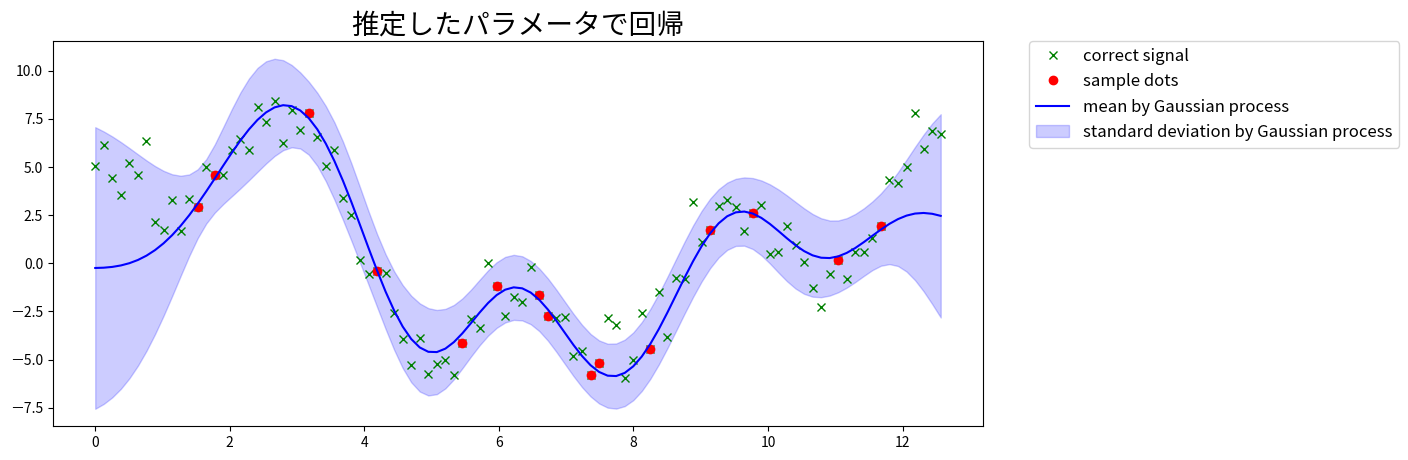

In [21]:
visualize(data_x,data_y,xtest,sample_index,mu,var,'推定したパラメータで回帰')

テキストで使用されているパラメータを使って描画して比較してみる。

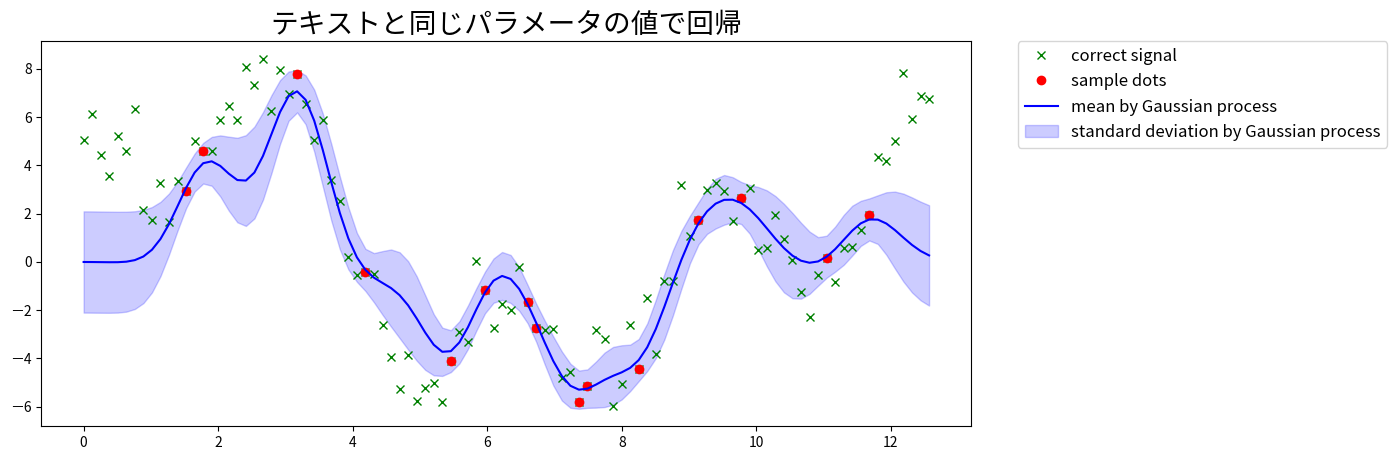

In [22]:
mu,var=predict(xtrain,ytrain,xtest,1.0,0.4,0.1)
visualize(data_x,data_y,xtest,sample_index,mu,var,'テキストと同じパラメータの値で回帰')